# To ensure GPU availability

In [1]:
import tensorflow as tf

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"CUDA is available. GPU device name: {gpus[0].name}")
    
    # Set memory growth to prevent TensorFlow from allocating all GPU memory
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Use the first GPU by default
    with tf.device('/GPU:0'):
        # Your code (model training, inference, etc.)
        pass
else:
    print("CUDA is not available.")

CUDA is available. GPU device name: /physical_device:GPU:0


# Importing necessary libraries

In [20]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import f1_score

# General imports
import random
import keras
from keras.callbacks import Callback


import shutil

# Copy the data to working directory

In [3]:
# Define paths
data_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
output_path = '/kaggle/working/Skin-disease-image'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)

# Checking Class distribution

Class counts: [7970, 1257, 2055, 3323, 3140, 1702, 2079, 2103, 1677, 1847]


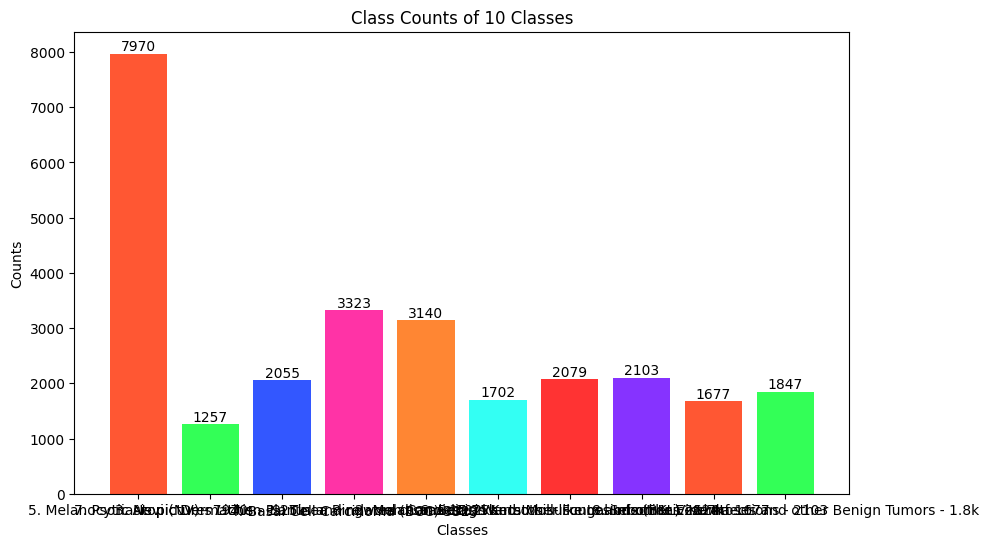

In [5]:
# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6', 
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 10 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Oversampling and Undersampling

In [6]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target
    
    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []
        
        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break
        
        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [7]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Processed 7012/7000 images for 2. Melanoma 15.75k
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7021/7000 images for 1. Eczema 1677
Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Oversampling and undersampling completed successfully.


# Checking class imbalance

Class counts: [7000, 6965, 6980, 6993, 6987, 6962, 6973, 7001, 6975, 6995]


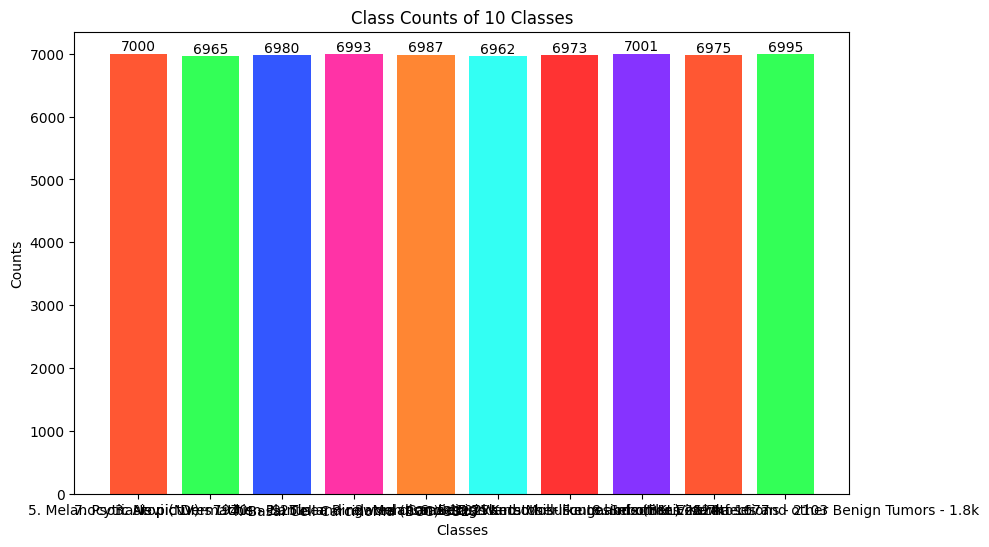

In [8]:
classes = os.listdir(output_path)
class_counts = [len(os.listdir(output_path + '/' + x)) for x in classes]
print("Class counts:", class_counts)


# Visualize class counts
plt.figure(figsize=(10, 6))
bars = plt.bar(classes, class_counts, color=[
    '#FF5733', '#33FF57', '#3357FF', '#FF33A6', 
    '#FF8633', '#33FFF3', '#FF3333', '#8633FF'
])
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts of 10 Classes')
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )
plt.show()

# Train and Test Split

In [9]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)
    
    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)
    
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    
    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    
    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val
    
    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]
    
    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
    
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


# Loading Images

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Display class names (optional)
print("Class Names:", class_names)

Found 48878 files belonging to 10 classes.
Found 10471 files belonging to 10 classes.
Class Names: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


# Preprocessing the data

In [11]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

# Model Building

In [12]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
base_model = keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3), 
    include_top=False,             
    weights='imagenet',
    pooling='max'
) 

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x) #output layer 
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train the model

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)

NameError: name 'val_labels' is not defined

# Model Accuracy Graph

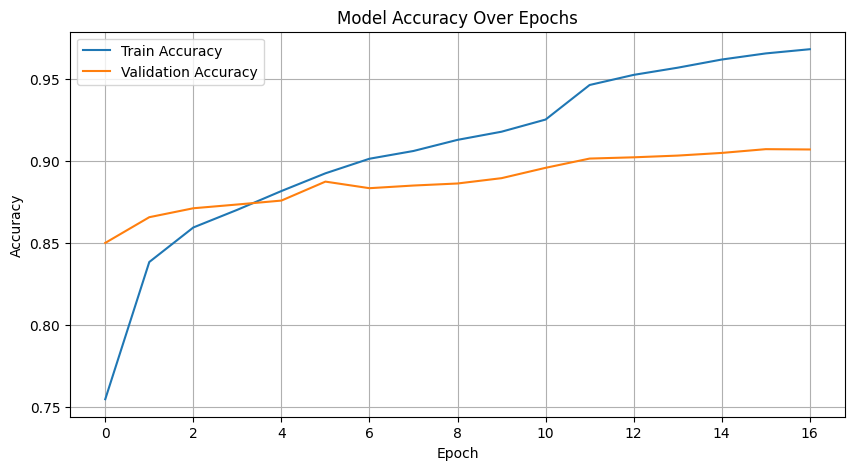

In [19]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing model.fit(...)
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Saving the model

In [14]:
# Save the model after training
model_save_path = '/kaggle/working/my_model.h5'
model.save(model_save_path)

# Optionally, display a message confirming the model is saved
print(f'Model saved at {model_save_path}')

Model saved at /kaggle/working/my_model.h5


In [15]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/my_model.h5')


In [16]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

# Path to your image
img_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/0_33.jpg'

# Load and resize the image
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)

# Expand dimensions to match model input (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image (EfficientNet style)
img_array = preprocess_input(img_array)


In [17]:
# Define class labels
class_names = ['Eczema1677', 'Warts Molluscum and other Viral Infections -', 'Melanoma15.75k',
               'Atopic Dermatitis-1.25k', 'BasalCellCarcinoma(BCC)3323', 'MelanocyticNevi(NV)-7970',
               'BenignKeratosis-', 'Psoriasis pictures Lichen Planus and related diseases-2k',
               'Seborrheic Keratoses and other Benign Tumors - 1.8k',
               'Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

#class_names = ['acne', 'alopecia', 'eczema', 'nailfungus', 'normal', 'psoriasis', 'ringworm', 'scabies', 'vitiligo', 'warts']
print("Predicted Class:", class_names[predicted_class])



1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Predicted Class: Eczema1677


In [18]:
import pandas as pd

# Map verbose class names to clean disease names
mapping = {
    'Eczema1677': 'Eczema',
    'Warts Molluscum and other Viral Infections -': 'Warts Molluscum',
    'Melanoma15.75k': 'Melanoma',
    'Atopic Dermatitis-1.25k': 'Atopic Dermatitis',
    'BasalCellCarcinoma(BCC)3323': 'BasalCellCarcinoma',
    'MelanocyticNevi(NV)-7970': 'MelanocyticNevi(NV)',
    'BenignKeratosis-': 'BenignKeratosis',
    'Psoriasis pictures Lichen Planus and related diseases-2k': 'Psoriasis',
    'Seborrheic Keratoses and other Benign Tumors - 1.8k': 'Seborrheic Keratoses',
    'Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 'Tinea Ringworm Candidiasis'
}

# OTC data for each disease
otc_data = {
    'Disease': [
        'Eczema', 'Warts Molluscum', 'Melanoma', 'Atopic Dermatitis',
        'BasalCellCarcinoma', 'MelanocyticNevi(NV)', 'BenignKeratosis',
        'Psoriasis', 'Seborrheic Keratoses', 'Tinea Ringworm Candidiasis'
    ],
    'OTC_Medicine': [
        'Hydrocortisone cream, moisturizers, anti-itch lotions',
        'No FDA-approved OTC treatment — consult doctor',
        'No OTC — requires medical treatment',
        'Hydrocortisone cream, moisturizers, anti-itch lotions',
        'No OTC — requires medical treatment',
        'No OTC — monitor and consult doctor if changed',
        'Moisturizers, salicylic acid creams',
        'Coal tar, salicylic acid, moisturizers',
        'No OTC — dermatologist removal if necessary',
        'Clotrimazole, Miconazole (antifungal creams)'
    ],
    'Notes': [
        'Helps reduce itching and inflammation.',
        'Usually resolves over time, but dermatologist advice is best.',
        'Melanoma is dangerous and must be seen by a professional.',
        'Same as eczema — moisturize and reduce itching.',
        'Requires biopsy and clinical intervention.',
        'Benign but monitor for size/color change.',
        'Softens and sheds keratotic lesions.',
        'Helpful for scaling and itching. Maintain moisturization.',
        'Benign; usually cosmetic concern.',
        'Keep area dry, use antifungal creams consistently.'
    ]
}

# Create DataFrame
medicine_df = pd.DataFrame(otc_data)

# Get clean disease name
#clean_disease = mapping[predicted_class]
predicted_label = class_names[predicted_class]  # Converts 1 → 'alopecia' etc.
clean_disease = mapping.get(predicted_label, predicted_label)  # Use mapping if available

# Get medicine info
med_info = medicine_df[medicine_df['Disease'] == clean_disease].iloc[0]

# Print results
print(f"\n✅ Disease: {clean_disease}")
print(f"💊 OTC Medicine: {med_info['OTC_Medicine']}")
print(f"📝 Notes: {med_info['Notes']}")



✅ Disease: Eczema
💊 OTC Medicine: Hydrocortisone cream, moisturizers, anti-itch lotions
📝 Notes: Helps reduce itching and inflammation.
